# Run

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
import time
import os
from scipy import signal
from scipy.signal import find_peaks
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import skdim

In [2]:
with open('Udata.pkl', 'rb') as file:
    Udata = pickle.load(file)

# Vamos remover a atividade 'jumping'
actis = ['climbingdown', 'climbingup', 'lying', 'running', 'sitting', 'standing', 'walking']
posis = ['chest', 'forearm', 'head', 'shin', 'thigh', 'upperarm', 'waist']
users = ['proband' + x for x in np.arange(1,16).astype(str)]
# proband2 não tem acc_climbingup_forearm
users.remove('proband2')
# Vamos remover usuários com menos de 21000 amostras
users.remove('proband1')
users.remove('proband4')
users.remove('proband7')
users.remove('proband14')

# Funções

In [3]:
def pcabase(X):
    M = np.ones((X.shape[0],1)).dot(X.mean(axis=0).reshape(1,X.shape[1]))
    R = (X-M).transpose().dot(X-M)
    l, vet = np.linalg.eig(R)
    inds = np.argsort(l)
    vet = vet[:,inds][:,::-1]
    return l, vet

In [4]:
def picotar(x, J, passo):
    N = x.shape[0]
    Nj = (N-J)//passo + 1
    X = np.zeros((Nj, J))
    for i in range(Nj):
        X[i,:] = x[(i*passo):(i*passo+J)]
    return X

In [5]:
def getDI(ex, ey, printFLag=False, resaFlag=True):
    if resaFlag:
        nex = np.linspace(ex.min(), ex.max(), 10000)
        ney = np.interp(nex, ex, ey)
        ex, ey = nex, ney
    k = 30
    janela = 10
    faixa = (max(ex)-min(ex))/k
    score = []
    dim = []
    b = []
    for i in range(k-janela+1):
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
        dim.append(regre.coef_[0])
        b.append(regre.intercept_)
        score.append(regre.score(ex[ni:ns].reshape(-1, 1), ey[ni:ns]))
    i = np.argmax(score)
    if printFLag:
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        plt.plot(ex,ey)
        plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim[i]+b[i])
        plt.title('DI: '+str(dim[i].round(1)))
    return dim[i]

In [6]:
def getCR(X):
    N = X.shape[0]
    L = N*(N-1)//2
    rx = np.zeros(L)
    cont = 0
    for i in range(N-1):
        for j in range(i+1,N):
            rx[cont] = max(abs(X[i,:]-X[j,:]))*2
            cont += 1
    rx = np.sort(rx)
    rx = rx[rx>0]
    L = rx.shape[0]
    ex = np.log2(rx)
    ey = np.log2(np.arange(1,L+1)/L)
    return ex, ey

In [7]:
def getDI2(ex, ey, printFLag=False, resaFlag=True):
    if resaFlag:
        nex = np.linspace(ex.min(), ex.max(), 10000)
        ney = np.interp(nex, ex, ey)
        ex, ey = nex, ney
    k = 30
    janela = 10
    faixa = (max(ex)-min(ex))/k
    score = []
    dim = []
    b = []
    for i in range(k-janela+1):
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
        dim.append(regre.coef_[0])
        b.append(regre.intercept_)
        score.append(regre.score(ex[ni:ns].reshape(-1, 1), ey[ni:ns]))
    i = np.argmax(score)
    if printFLag:
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        plt.plot(ex,ey)
        plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim[i]+b[i])
    return dim, score

In [8]:
def getDI2(ex, ey, printFLag=False, resaFlag=True):
    if resaFlag:
        nex = np.linspace(ex.min(), ex.max(), 10000)
        ney = np.interp(nex, ex, ey)
        ex, ey = nex, ney
    k = 30
    janela = 10
    faixa = (max(ex)-min(ex))/k
    score = []
    dim = []
    b = []
    for i in range(15-janela+1):
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
        dim.append(regre.coef_[0])
        b.append(regre.intercept_)
        score.append(regre.score(ex[ni:ns].reshape(-1, 1), ey[ni:ns]))
    i = np.argmax(score)
    if printFLag:
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        plt.figure()
        plt.plot(ex,ey)
        plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim[i]+b[i])
        plt.title('DI: '+str(dim[i].round(1))+' Região: '+str(np.round(min(ex)+faixa*(i+janela/2), 1)))
        plt.show()
    return dim[i], min(ex)+faixa*(i+janela/2)

In [9]:
def getCRNN(X, k):
    N = X.shape[0]
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    aux = []
    for i in range(N):
        aux.append(np.vstack((np.ones(k, dtype=np.int32)*i, indices[i,1:].astype(int))))
    inds = np.hstack(aux)
    L = inds.shape[1]
    rx = np.zeros(L)
    for i in range(L):
        rx[i] = max(abs(X[inds[0,i],:]-X[inds[1,i],:]))*2
    rx = np.sort(rx)
    rx = rx[rx>0]
    L = rx.shape[0]
    ex = np.log2(rx)
    ey = np.log2(np.arange(1,L+1)/L)
    return ex, ey

In [10]:
def getDIfix(ex, ey, printFLag=False, resaFlag=True):
    if resaFlag:
        nex = np.linspace(ex.min(), ex.max(), 10000)
        ney = np.interp(nex, ex, ey)
        ex, ey = nex, ney
    ni = np.sum(ex<-8)
    ns = np.sum(ex<-4)
    regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
    dim = regre.coef_[0]
    b = regre.intercept_
    if printFLag:
        plt.figure()
        plt.plot(ex,ey)
        plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim+b)
        plt.title('DI: '+str(dim.round(1))+' Região: -6')
        plt.show()
    return dim

# Exps iniciais

In [16]:
nu = 0
Na = 21000
Ne = 3000
nd = 0
na = 0
X = np.array(Udata[nu][nd])[na, :, :3]/10
inds = np.random.permutation(Na)[:Ne]
ex, ey = getCR(X[inds])

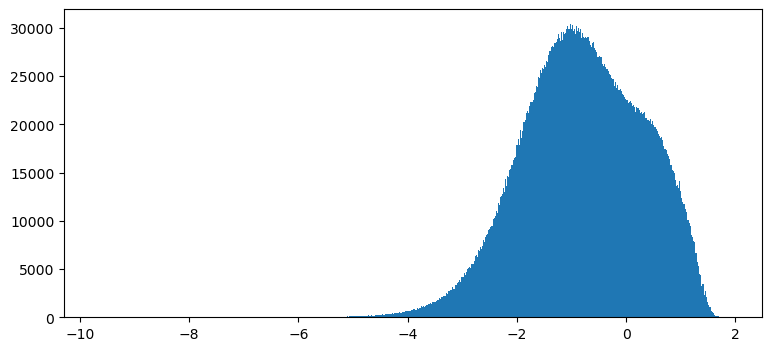

In [17]:
plt.figure(figsize=(9,4))
aux = plt.hist(ex, bins='auto')

In [14]:
np.sum(ex<-6)

674

In [10]:
np.sum(ex<-4)/ex.shape[0]

0.004037345781927309

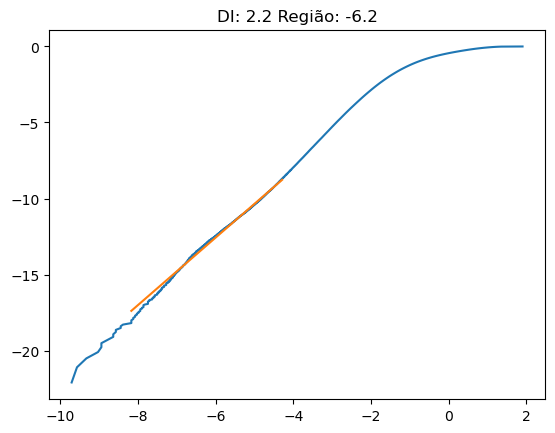

(2.2207575723659456, -6.224930925100251)

In [18]:
getDI2(ex, ey, printFLag=True, resaFlag=False)

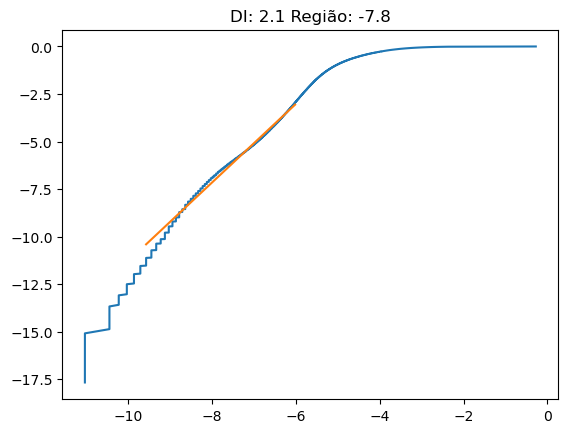

(2.06936121293861, -7.80320759473862)

In [56]:
getDI2(ex, ey, printFLag=True, resaFlag=False)

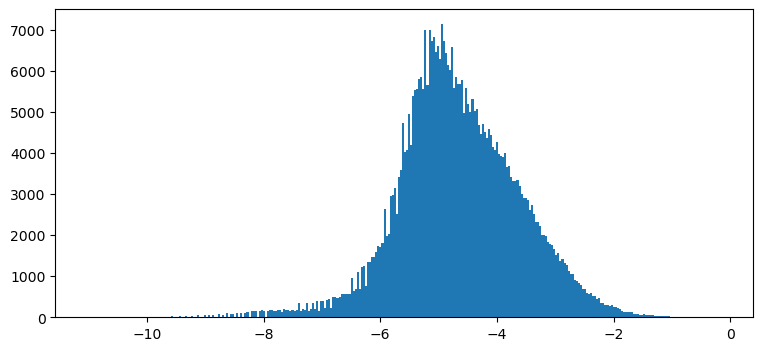

In [19]:
ex, ey = getCRNN(X, 20)
plt.figure(figsize=(9,4))
aux = plt.hist(ex, bins='auto')

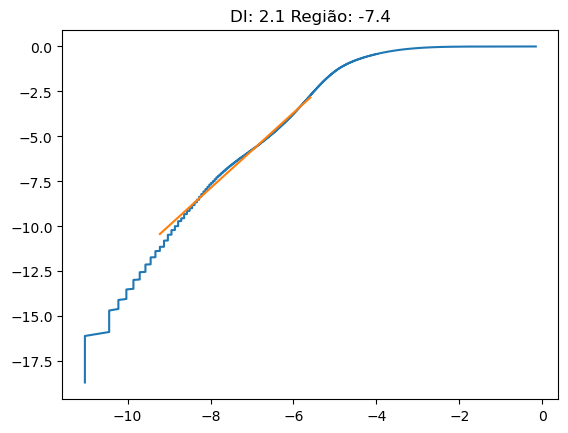

(2.0922540761848865, -7.404906167965027)

In [21]:
getDI2(ex, ey, printFLag=True, resaFlag=False)

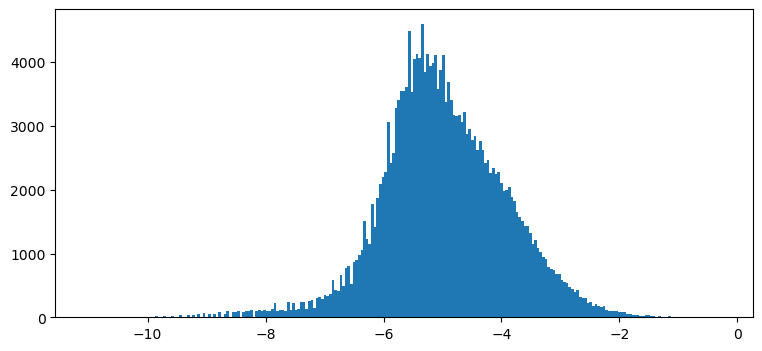

In [53]:
plt.figure(figsize=(9,4))
aux = plt.hist(ex, bins='auto')

# Incluir janela temporal

## Preliminares

In [10]:
nu = 0
Na = 21000
nd = 0
na = 0
X = np.array(Udata[nu][nd])[na, :, :3]/10
aux = []
for i in range(3):
    aux.append(picotar(X[:,i], 30, 30))
X = np.hstack(aux)
X.shape

(700, 90)

In [11]:
ex, ey = getCRNN(X, 20)

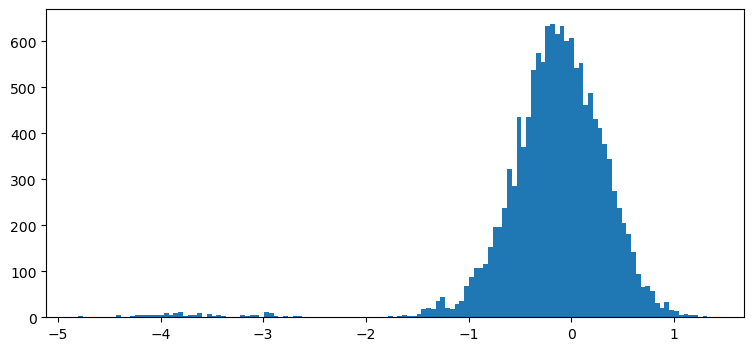

In [12]:
plt.figure(figsize=(9,4))
aux = plt.hist(ex, bins='auto')

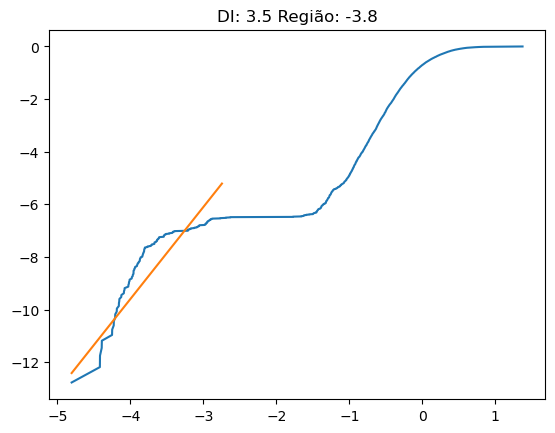

(3.4985239663109913, -3.7745976106581427)

In [14]:
getDI2(ex, ey, printFLag=True, resaFlag=True)

In [10]:
nu = 0
Na = 21000
Ne = 3000
nd = 0
na = 0
X = np.array(Udata[nu][nd])[na, :, :3]/10
aux = []
for i in range(3):
    aux.append(picotar(X[:,i], 30, 1))
X = np.hstack(aux)
X.shape

(20971, 90)

In [11]:
ex, ey = getCRNN(X, 10)

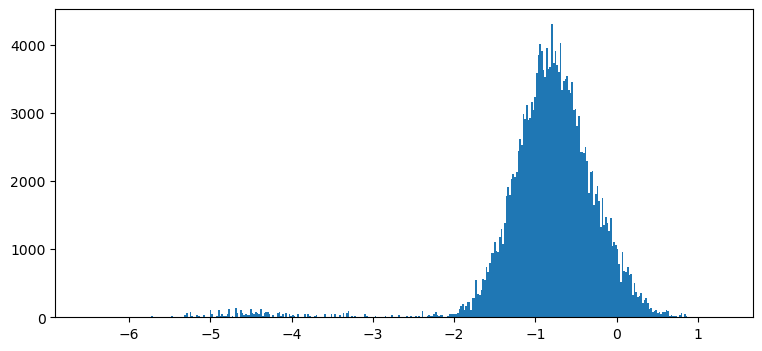

In [12]:
plt.figure(figsize=(9,4))
aux = plt.hist(ex, bins='auto')

3.7457167986822233

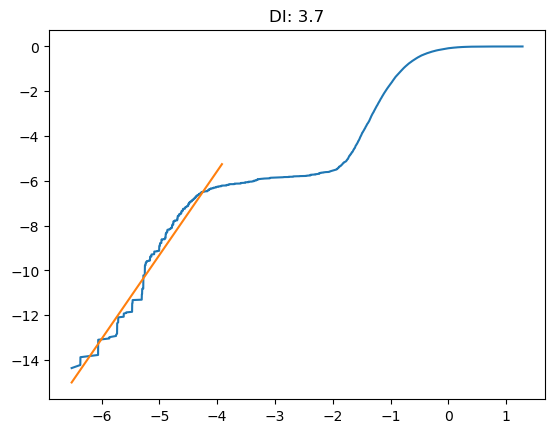

In [14]:
getDI(ex, ey, printFLag=True, resaFlag=True)

In [ ]:
nu = 0
J = 20
k = 5
DIest = np.zeros((7,7))
pos = np.zeros((7,7))
for nd in tqdm(range(len(posis))):
    for na in range(len(actis)):
        X = np.array(Udata[nu][nd])[na, :, :3]/10
        aux = []
        for i in range(X.shape[1]):
            aux.append(picotar(X[:,i], J, 1))
        X = np.hstack(aux)
        ex, ey = getCRNN(X, k)
        DIest[na,nd], pos[na,nd] = getDI2(ex,ey)

In [36]:
fig = px.imshow(DIest, width=800, title='Acc do usuário '+users[nu],
                labels=dict(y='Atividade', x='Posição', color='Dimensão estimada'),
                y=actis,
                x=posis)
fig.show()

## Analisando resultado

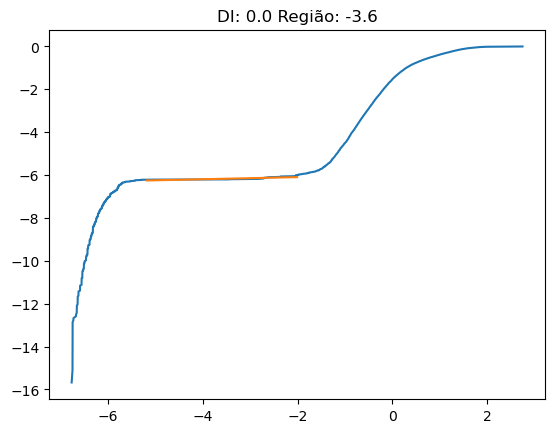

In [40]:
nu = 0
J = 20
k = 5
nd = 3
na = 0
X = np.array(Udata[nu][nd])[na, :, :3]/10
aux = []
for i in range(X.shape[1]):
    aux.append(picotar(X[:,i], J, 1))
X = np.hstack(aux)
ex, ey = getCRNN(X, k)
DIest[na,nd], pos[na,nd] = getDI2(ex,ey, printFLag=True, resaFlag=True)

In [50]:
i = 0
k = 140
janela = 10
faixa = (max(ex)-min(ex))/k
limi = min(ex)+faixa*i
lims = min(ex)+faixa*(i+janela)
ni = np.argmin(abs(ex-limi))
ns = np.argmin(abs(ex-lims))
regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
dim = regre.coef_[0]
b = regre.intercept_

Text(0.5, 1.0, 'DI: 8.6')

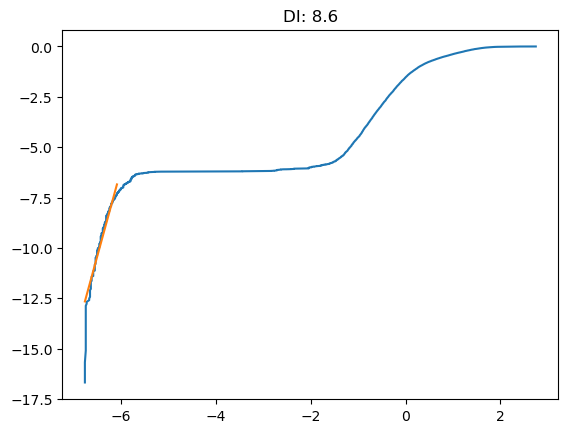

In [51]:
plt.plot(ex,ey)
plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim+b)
plt.title('DI: '+str(dim.round(1)))

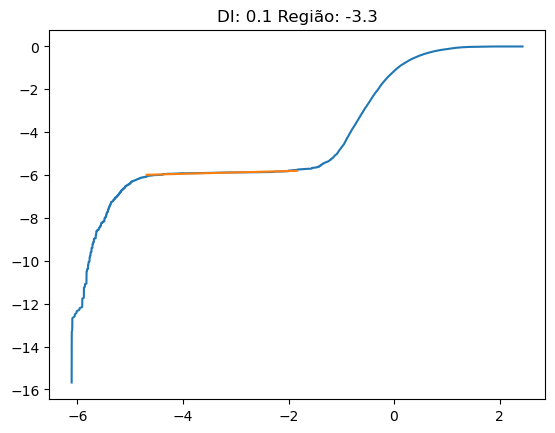

In [52]:
nu = 0
J = 20
k = 5
nd = 4
na = 0
X = np.array(Udata[nu][nd])[na, :, :3]/10
aux = []
for i in range(X.shape[1]):
    aux.append(picotar(X[:,i], J, 1))
X = np.hstack(aux)
ex, ey = getCRNN(X, k)
DIest[na,nd], pos[na,nd] = getDI2(ex,ey, printFLag=True, resaFlag=True)

Text(0.5, 1.0, 'DI: 9.9')

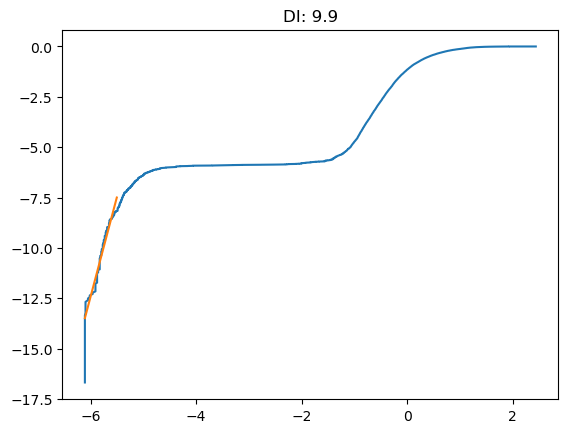

In [53]:
i = 0
k = 140
janela = 10
faixa = (max(ex)-min(ex))/k
limi = min(ex)+faixa*i
lims = min(ex)+faixa*(i+janela)
ni = np.argmin(abs(ex-limi))
ns = np.argmin(abs(ex-lims))
regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
dim = regre.coef_[0]
b = regre.intercept_
plt.plot(ex,ey)
plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim+b)
plt.title('DI: '+str(dim.round(1)))

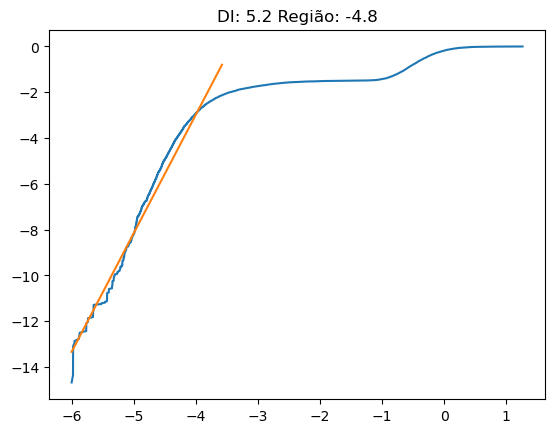

In [54]:
nu = 0
J = 20
k = 5
nd = 0
na = 3
X = np.array(Udata[nu][nd])[na, :, :3]/10
aux = []
for i in range(X.shape[1]):
    aux.append(picotar(X[:,i], J, 1))
X = np.hstack(aux)
ex, ey = getCRNN(X, k)
DIest[na,nd], pos[na,nd] = getDI2(ex,ey, printFLag=True, resaFlag=True)

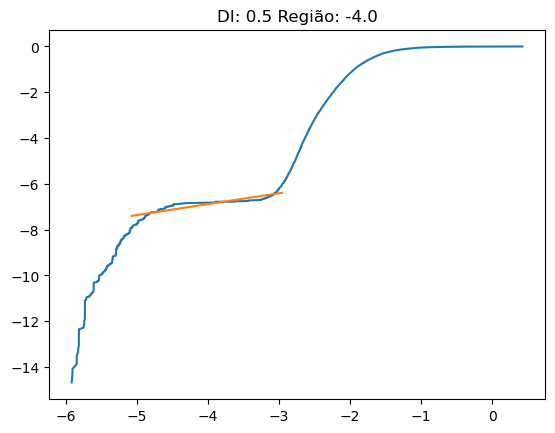

In [55]:
nu = 0
J = 20
k = 5
nd = 0
na = 6
X = np.array(Udata[nu][nd])[na, :, :3]/10
aux = []
for i in range(X.shape[1]):
    aux.append(picotar(X[:,i], J, 1))
X = np.hstack(aux)
ex, ey = getCRNN(X, k)
DIest[na,nd], pos[na,nd] = getDI2(ex,ey, printFLag=True, resaFlag=True)

Text(0.5, 1.0, 'DI: 10.3')

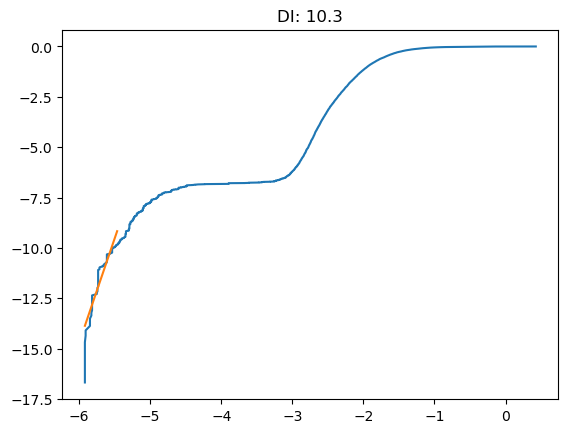

In [56]:
i = 0
k = 140
janela = 10
faixa = (max(ex)-min(ex))/k
limi = min(ex)+faixa*i
lims = min(ex)+faixa*(i+janela)
ni = np.argmin(abs(ex-limi))
ns = np.argmin(abs(ex-lims))
regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
dim = regre.coef_[0]
b = regre.intercept_
plt.plot(ex,ey)
plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim+b)
plt.title('DI: '+str(dim.round(1)))

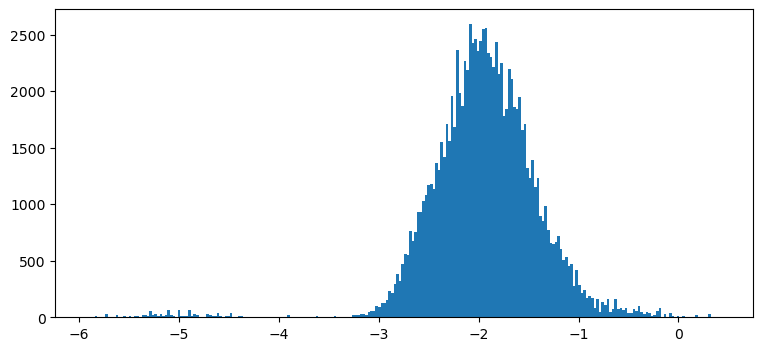

In [57]:
plt.figure(figsize=(9,4))
aux = plt.hist(ex, bins='auto')

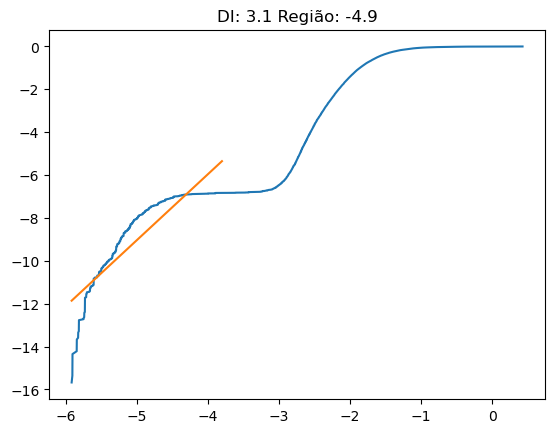

In [58]:
nu = 0
J = 20
k = 10
nd = 0
na = 6
X = np.array(Udata[nu][nd])[na, :, :3]/10
aux = []
for i in range(X.shape[1]):
    aux.append(picotar(X[:,i], J, 1))
X = np.hstack(aux)
ex, ey = getCRNN(X, k)
DIest[na,nd], pos[na,nd] = getDI2(ex,ey, printFLag=True, resaFlag=True)

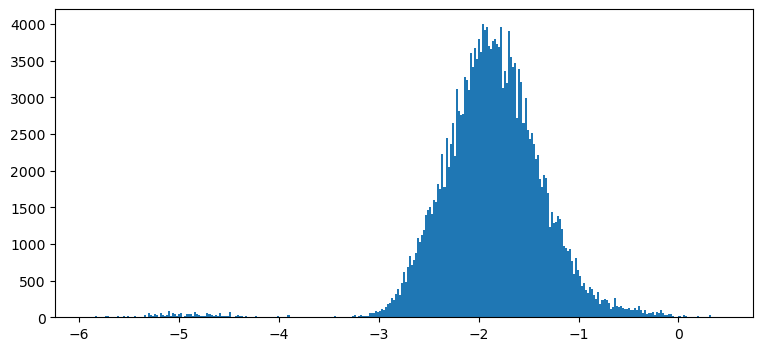

In [59]:
plt.figure(figsize=(9,4))
aux = plt.hist(ex, bins='auto')

Text(0.5, 1.0, 'DI: 6.1')

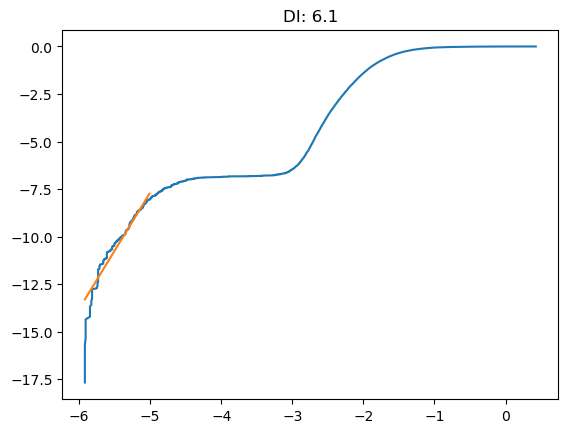

In [64]:
i = 0
k = 70
janela = 10
faixa = (max(ex)-min(ex))/k
limi = min(ex)+faixa*i
lims = min(ex)+faixa*(i+janela)
ni = np.argmin(abs(ex-limi))
ns = np.argmin(abs(ex-lims))
regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
dim = regre.coef_[0]
b = regre.intercept_
plt.plot(ex,ey)
plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim+b)
plt.title('DI: '+str(dim.round(1)))

## Acc+gyr

In [ ]:
Na = 21000*7
k = 5
DIest = np.zeros((10,7))
for nd in tqdm(range(len(posis))):
    for nu in range(10):
        X = np.array(Udata[nu][nd])[:, :, :3].reshape(Na,3)/10
        aux = []
        for i in range(X.shape[1]):
            aux.append(picotar(X[:,i], J, 1))
        X = np.hstack(aux)
        ex, ey = getCRNN(X, k)
        DIest[nu,nd], aux = getDI2(ex,ey)
DIest.round(1)

  0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
Na = 21000*7
J = 20
k = 5
nd = 0
nu = 0
X = np.array(Udata[nu][nd])[:, :, :3].reshape(Na,3)/10
aux = []
for i in range(X.shape[1]):
    aux.append(picotar(X[:,i], J, 1))
X = np.hstack(aux)
ex, ey = getCRNN(X, k)

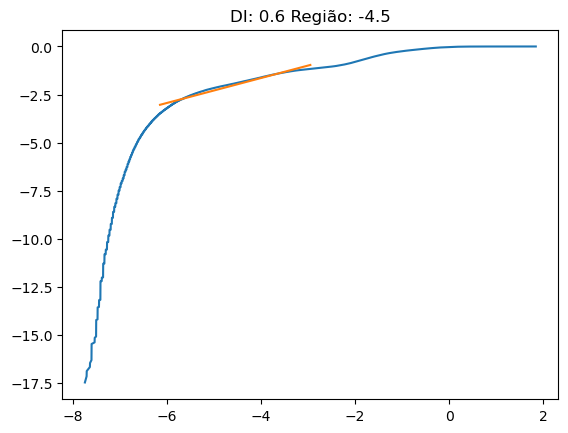

(0.6487673918808224, -4.5473753647306285)

In [12]:
getDI2(ex,ey, printFLag=True, resaFlag=True)

Text(0.5, 1.0, 'DI: 9.6')

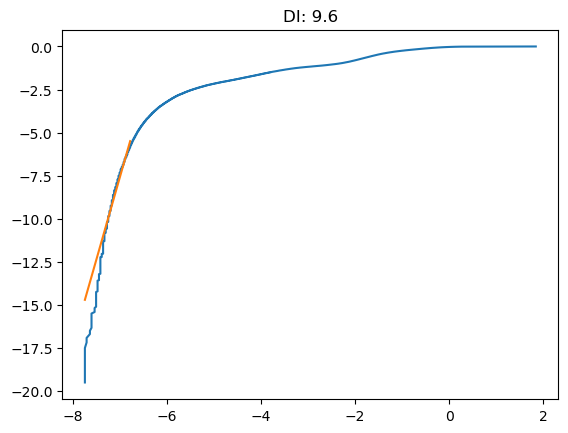

In [15]:
i = 0
k = 100
janela = 10
faixa = (max(ex)-min(ex))/k
limi = min(ex)+faixa*i
lims = min(ex)+faixa*(i+janela)
ni = np.argmin(abs(ex-limi))
ns = np.argmin(abs(ex-lims))
regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
dim = regre.coef_[0]
b = regre.intercept_
plt.plot(ex,ey)
plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim+b)
plt.title('DI: '+str(dim.round(1)))

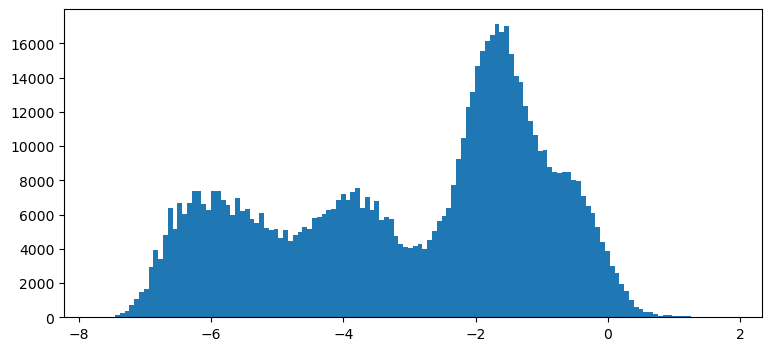

In [13]:
plt.figure(figsize=(9,4))
aux = plt.hist(ex, bins='auto')

In [ ]:
nu = 0
J = 20
k = 5
DIest = np.zeros((7,7))
pos = np.zeros((7,7))
for nd in tqdm(range(len(posis))):
    for na in range(len(actis)):
        X = np.array(Udata[nu][nd])[na, :, :3]/10
        aux = []
        for i in range(X.shape[1]):
            aux.append(picotar(X[:,i], J, 1))
        X = np.hstack(aux)
        ex, ey = getCRNN(X, k)
        DIest[na,nd], pos[na,nd] = getDI2(ex,ey)

In [23]:
X = np.array(Udata[nu][nd])[na, :, :3]/10
px.scatter(X)

## PCA com vizinhos locais

In [11]:
nu = 0
Na = 21000
nd = 0
na = 0
X = np.array(Udata[nu][nd])[na, :, :3]/10
aux = []
for i in range(3):
    aux.append(picotar(X[:,i], 30, 15))
X = np.hstack(aux)
# scaler = StandardScaler()
# scaled_X = scaler.fit_transform(X)
scaled_X = X
N = X.shape[0]
# k = X.shape[1]+1
k = 20
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(scaled_X)
distances, indices = nbrs.kneighbors(scaled_X)
# Os vizinhos mais próximos são diferentes para os dados normlizados!

In [12]:
l, vet = pcabase(scaled_X)
id = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
print(id)
px.scatter(l.cumsum()/l.sum(), range_y=[0,1.1])

17


In [13]:
px.line(vet[:,:id])

In [128]:
px.scatter(np.real(l.cumsum()/l.sum()))

In [139]:
lID = np.zeros(N)
for i in range(N):
    l, vet = pcabase(scaled_X[indices[i,1:]])
    lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
print(lID.mean().round(1), lID.std().round(1))
px.histogram(lID)

9.5 1.3


In [83]:
lID = np.zeros(N)
for i in range(N):
    l, vet = pcabase(scaled_X[indices[i,1:]])
    lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
print(lID.mean().round(1), lID.std().round(1))
px.histogram(lID)

17.8 0.7


In [95]:
lID = np.zeros(N)
for i in range(N):
    l, vet = pcabase(X[indices[i,1:]])
    lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
print(lID.mean().round(1), lID.std().round(1))
px.histogram(lID)

12.7 0.9


In [99]:
lpca = skdim.id.lPCA().fit_pw(X, n_neighbors = 91, n_jobs = 1)
px.histogram(lpca.dimension_pw_)

In [100]:
lpca = skdim.id.lPCA().fit_pw(scaled_X, n_neighbors = 91, n_jobs = 1)
px.histogram(lpca.dimension_pw_)

In [102]:
danco = skdim.id.DANCo().fit(X)
danco.dimension_

9.978238742339462

In [103]:
danco = skdim.id.DANCo().fit(scaled_X)
danco.dimension_

10.0

In [107]:
twonn = skdim.id.TwoNN().fit_pw(X, n_neighbors = 91, n_jobs = 1)
px.histogram(twonn.dimension_pw_)

In [106]:
twonn = skdim.id.TwoNN().fit_pw(scaled_X, n_neighbors = 91, n_jobs = 1)
px.histogram(twonn.dimension_pw_)

In [109]:
corrint = skdim.id.CorrInt().fit_pw(X, n_neighbors = 91, n_jobs = 1)
px.histogram(corrint.dimension_pw_)

In [108]:
corrint = skdim.id.CorrInt().fit_pw(scaled_X, n_neighbors = 91, n_jobs = 1)
px.histogram(corrint.dimension_pw_)

5.223566619826247

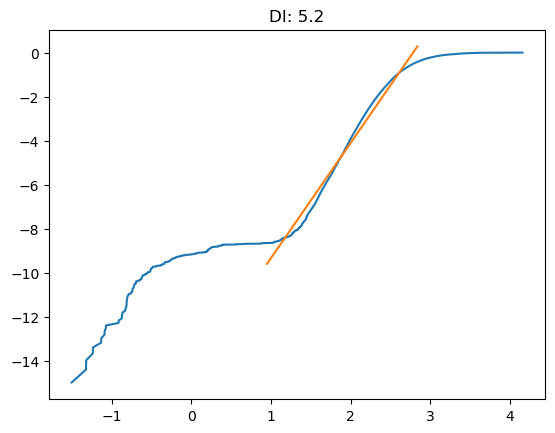

In [88]:
ex, ey = getCRNN(scaled_X, k)
getDI(ex, ey, printFLag=True, resaFlag=True)

6.166893704989538

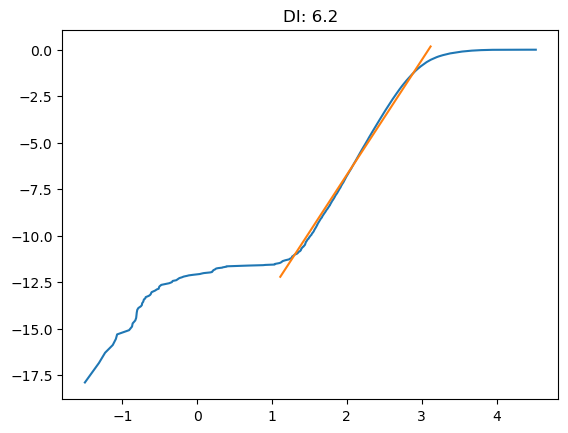

In [93]:
ex, ey = getCR(scaled_X)
getDI(ex, ey, printFLag=True, resaFlag=True)

## Juntando as classes

In [11]:
nu = 0
nd = 0
aux1 = []
for na in range(7):
    aux = []
    for i in range(3):
        aux.append(picotar(np.array(Udata[nu][nd])[na, :, i]/10, 30, 15))
    aux1.append(np.hstack(aux))
X = np.vstack(aux1)
N = X.shape[0]
k = X.shape[1]+1
# k = 20
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [40]:
l, vet = pcabase(X)
id = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
print(id)
px.scatter(l.cumsum()/l.sum(), range_y=[0,1.1])

7


In [41]:
px.line(vet[:,:id])

In [44]:
lID = np.zeros(N)
for i in range(N):
    l, vet = pcabase(X[indices[i,:]])
    lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
print(lID.mean().round(1), lID.std().round(1))
px.histogram(lID)

18.3 4.9


In [47]:
nu = 0
nd = 1
aux1 = []
for na in range(7):
    aux = []
    for i in range(3):
        aux.append(picotar(np.array(Udata[nu][nd])[na, :, i]/10, 30, 15))
    aux1.append(np.hstack(aux))
X = np.vstack(aux1)
N = X.shape[0]
k = X.shape[1]+1
# k = 20
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [48]:
lID = np.zeros(N)
for i in range(N):
    l, vet = pcabase(X[indices[i,:]])
    lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
print(lID.mean().round(1), lID.std().round(1))
px.histogram(lID)

15.4 4.8


In [51]:
nu = 0
nd = 0
aux1 = []
for na in range(7):
    aux = []
    for i in range(3):
        aux.append(picotar(np.array(Udata[nu][nd])[na, :, i]/10, 30, 15))
    aux1.append(np.hstack(aux))
X = np.vstack(aux1)
N = X.shape[0]
k = 20
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [52]:
lID = np.zeros(N)
for i in range(N):
    l, vet = pcabase(X[indices[i,:]])
    lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
print(lID.mean().round(1), lID.std().round(1))
px.histogram(lID)

10.6 1.4


In [53]:
nu = 1
nd = 0
aux1 = []
for na in range(7):
    aux = []
    for i in range(3):
        aux.append(picotar(np.array(Udata[nu][nd])[na, :, i]/10, 30, 15))
    aux1.append(np.hstack(aux))
X = np.vstack(aux1)
N = X.shape[0]
k = 20
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [54]:
lID = np.zeros(N)
for i in range(N):
    l, vet = pcabase(X[indices[i,:]])
    lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
print(lID.mean().round(1), lID.std().round(1))
px.histogram(lID)

10.4 1.4


## Expandindo testes...

In [58]:
DIest = np.zeros((10,7))
for nu in tqdm(range(10)):
    for nd in range(7):
        aux1 = []
        for na in range(7):
            aux = []
            for i in range(3):
                aux.append(picotar(np.array(Udata[nu][nd])[na, :, i]/10, 30, 15))
            aux1.append(np.hstack(aux))
        X = np.vstack(aux1)
        N = X.shape[0]
        k = 20
        nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
        distances, indices = nbrs.kneighbors(X)
        lID = np.zeros(N)
        for i in range(N):
            l, vet = pcabase(X[indices[i,:]])
            lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
        DIest[nu,nd] = lID.mean()

100%|██████████| 10/10 [35:19<00:00, 211.95s/it]


In [59]:
fig = px.imshow(DIest, width=800,
                labels=dict(y='Usuário', x='Posição', color='Dimensão estimada'),
                y=users,
                x=posis)
fig.show()

In [112]:
nu = 0
J = 30
k = 91
DIest = np.zeros((7,7))
pos = np.zeros((7,7))
for nd in tqdm(range(len(posis))):
    for na in range(len(actis)):
        X = np.array(Udata[nu][nd])[na, :, :3]/10
        aux = []
        for i in range(X.shape[1]):
            aux.append(picotar(X[:,i], J, J))
        X = np.hstack(aux)
        N = X.shape[0]        
        nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
        distances, indices = nbrs.kneighbors(X)
        lID = np.zeros(N)
        for i in range(N):
            l, vet = pcabase(X[indices[i,1:]])
            lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
        DIest[na,nd] = lID.mean()

100%|██████████| 7/7 [00:47<00:00,  6.74s/it]


In [113]:
fig = px.imshow(DIest, width=800, title='Acc do usuário '+users[nu],
                labels=dict(y='Atividade', x='Posição', color='Dimensão estimada'),
                y=actis,
                x=posis)
fig.show()

In [114]:
nu = 0
J = 30
k = 91
DIest = np.zeros((7,7))
pos = np.zeros((7,7))
for nd in tqdm(range(len(posis))):
    for na in range(len(actis)):
        X = np.array(Udata[nu][nd])[na, :, :3]/10
        aux = []
        for i in range(X.shape[1]):
            aux.append(picotar(X[:,i], J, J))
        X = np.hstack(aux)        
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        N = X.shape[0]        
        nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
        distances, indices = nbrs.kneighbors(X)
        lID = np.zeros(N)
        for i in range(N):
            l, vet = pcabase(X[indices[i,1:]])
            lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
        DIest[na,nd] = lID.mean()

100%|██████████| 7/7 [01:05<00:00,  9.41s/it]


In [115]:
fig = px.imshow(DIest, width=800, title='Acc do usuário '+users[nu],
                labels=dict(y='Atividade', x='Posição', color='Dimensão estimada'),
                y=actis,
                x=posis)
fig.show()

## Vamos analisar as regiões do manifold

In [11]:
nu = 0
nd = 0
aux1 = []
for na in range(7):
    aux = []
    for i in range(3):
        aux.append(picotar(np.array(Udata[nu][nd])[na, :, i]/10, 30, 15))
    aux1.append(np.hstack(aux))
X = np.vstack(aux1)
N = X.shape[0]
k = X.shape[1]
# k = 20
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [12]:
lID = np.zeros(N)
dists = np.zeros(N)
for i in range(N):
    dists[i] = distance.euclidean(X[indices[i,0]], X[indices[i,-1]])
    l, vet = pcabase(X[indices[i,:]])
    lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
print(lID.mean().round(1), lID.std().round(1))
px.histogram(lID)

18.2 4.9


In [25]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(y=lID, mode="markers"), row=1, col=1)
fig.add_trace(go.Scatter(y=dists, mode="lines"), row=2, col=1)
fig.update_layout(height=700)
fig.show()

In [46]:
nu = 0
nd = 0
aux1 = []
for na in range(7):
    aux = []
    for i in range(3):
        aux.append(picotar(np.array(Udata[nu][nd])[na, :, i]/10, 30, 15))
    aux1.append(np.hstack(aux))
X = np.vstack(aux1)
N = X.shape[0]
k = X.shape[1]
# k = 20
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
lID = np.zeros(N)
dists = np.zeros(N)
for i in range(N):
    dists[i] = distance.euclidean(X[indices[i,0]], X[indices[i,-1]])
    l, vet = pcabase(X[indices[i,:]])
    lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(y=lID, mode="lines"), row=1, col=1)
fig.add_trace(go.Scatter(y=dists, mode="lines"), row=2, col=1)
fig.update_layout(height=700,
    xaxis=dict(
        tickvals=np.arange(7)*1399,  # Define as posições dos rótulos
        ticktext=actis  # Define os textos dos rótulos
    )
)
fig.show()

In [47]:
nu = 1
nd = 0
aux1 = []
for na in range(7):
    aux = []
    for i in range(3):
        aux.append(picotar(np.array(Udata[nu][nd])[na, :, i]/10, 30, 15))
    aux1.append(np.hstack(aux))
X = np.vstack(aux1)
N = X.shape[0]
k = X.shape[1]
# k = 20
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
lID = np.zeros(N)
dists = np.zeros(N)
for i in range(N):
    dists[i] = distance.euclidean(X[indices[i,0]], X[indices[i,-1]])
    l, vet = pcabase(X[indices[i,:]])
    lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(y=lID, mode="lines"), row=1, col=1)
fig.add_trace(go.Scatter(y=dists, mode="lines"), row=2, col=1)
fig.update_layout(height=700,
    xaxis=dict(
        tickvals=np.arange(7)*1399,  # Define as posições dos rótulos
        ticktext=actis  # Define os textos dos rótulos
    )
)
fig.show()

In [48]:
nu = 2
nd = 0
aux1 = []
for na in range(7):
    aux = []
    for i in range(3):
        aux.append(picotar(np.array(Udata[nu][nd])[na, :, i]/10, 30, 15))
    aux1.append(np.hstack(aux))
X = np.vstack(aux1)
N = X.shape[0]
k = X.shape[1]
# k = 20
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
lID = np.zeros(N)
dists = np.zeros(N)
for i in range(N):
    dists[i] = distance.euclidean(X[indices[i,0]], X[indices[i,-1]])
    l, vet = pcabase(X[indices[i,:]])
    lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(y=lID, mode="lines"), row=1, col=1)
fig.add_trace(go.Scatter(y=dists, mode="lines"), row=2, col=1)
fig.update_layout(height=700,
    xaxis=dict(
        tickvals=np.arange(7)*1399,  # Define as posições dos rótulos
        ticktext=actis  # Define os textos dos rótulos
    )
)
fig.show()

In [49]:
nu = 2
nd = 2
aux1 = []
for na in range(7):
    aux = []
    for i in range(3):
        aux.append(picotar(np.array(Udata[nu][nd])[na, :, i]/10, 30, 15))
    aux1.append(np.hstack(aux))
X = np.vstack(aux1)
N = X.shape[0]
k = X.shape[1]
# k = 20
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
lID = np.zeros(N)
dists = np.zeros(N)
for i in range(N):
    dists[i] = distance.euclidean(X[indices[i,0]], X[indices[i,-1]])
    l, vet = pcabase(X[indices[i,:]])
    lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(y=lID, mode="lines"), row=1, col=1)
fig.add_trace(go.Scatter(y=dists, mode="lines"), row=2, col=1)
fig.update_layout(height=700,
    xaxis=dict(
        tickvals=np.arange(7)*1399,  # Define as posições dos rótulos
        ticktext=actis  # Define os textos dos rótulos
    )
)
fig.show()

In [50]:
nu = 4
nd = 4
aux1 = []
for na in range(7):
    aux = []
    for i in range(3):
        aux.append(picotar(np.array(Udata[nu][nd])[na, :, i]/10, 30, 15))
    aux1.append(np.hstack(aux))
X = np.vstack(aux1)
N = X.shape[0]
k = X.shape[1]
# k = 20
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
lID = np.zeros(N)
dists = np.zeros(N)
for i in range(N):
    dists[i] = distance.euclidean(X[indices[i,0]], X[indices[i,-1]])
    l, vet = pcabase(X[indices[i,:]])
    lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(y=lID, mode="lines"), row=1, col=1)
fig.add_trace(go.Scatter(y=dists, mode="lines"), row=2, col=1)
fig.update_layout(height=700,
    xaxis=dict(
        tickvals=np.arange(7)*1399,  # Define as posições dos rótulos
        ticktext=actis  # Define os textos dos rótulos
    )
)
fig.show()

In [51]:
nu = -1
nd = -1
aux1 = []
for na in range(7):
    aux = []
    for i in range(3):
        aux.append(picotar(np.array(Udata[nu][nd])[na, :, i]/10, 30, 15))
    aux1.append(np.hstack(aux))
X = np.vstack(aux1)
N = X.shape[0]
k = X.shape[1]
# k = 20
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
lID = np.zeros(N)
dists = np.zeros(N)
for i in range(N):
    dists[i] = distance.euclidean(X[indices[i,0]], X[indices[i,-1]])
    l, vet = pcabase(X[indices[i,:]])
    lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(y=lID, mode="lines"), row=1, col=1)
fig.add_trace(go.Scatter(y=dists, mode="lines"), row=2, col=1)
fig.update_layout(height=700,
    xaxis=dict(
        tickvals=np.arange(7)*1399,  # Define as posições dos rótulos
        ticktext=actis  # Define os textos dos rótulos
    )
)
fig.show()

In [52]:
nu = 0
nd = 4
aux1 = []
for na in range(7):
    aux = []
    for i in range(3):
        aux.append(picotar(np.array(Udata[nu][nd])[na, :, i]/10, 30, 15))
    aux1.append(np.hstack(aux))
X = np.vstack(aux1)
N = X.shape[0]
k = X.shape[1]
# k = 20
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
lID = np.zeros(N)
dists = np.zeros(N)
for i in range(N):
    dists[i] = distance.euclidean(X[indices[i,0]], X[indices[i,-1]])
    l, vet = pcabase(X[indices[i,:]])
    lID[i] = np.nonzero(l.cumsum()/l.sum() > 0.9)[0][0] + 1
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(y=lID, mode="lines"), row=1, col=1)
fig.add_trace(go.Scatter(y=dists, mode="lines"), row=2, col=1)
fig.update_layout(height=700,
    xaxis=dict(
        tickvals=np.arange(7)*1399,  # Define as posições dos rótulos
        ticktext=actis  # Define os textos dos rótulos
    )
)
fig.show()

In [53]:
posis

['chest', 'forearm', 'head', 'shin', 'thigh', 'upperarm', 'waist']